### RNN - LSTM 

**시계열 데이터를 처리하기 위해서 어떤 모델을 쓸거냐 > 연속적으로 들어오는 데이터셋을 인풋으로 받아서 이게 낙상인지 아닌지를 판단하는걸 위해서 어떤 모델을 훈련시켜서 쓸거냐**

RNN -> LSTM 사용이유 : 수치에서 패턴학습이 가능한 RNN을 장기간 학습을 위해서 보완된 버전인 LSTM으로 사용

RNN 자체가 수치적인 데이터에서 패턴학습을 하는것이고 문제가 있었던 점은 이 학습이 계속되면서 (장기간) gradient vanishing이 일어나는 것이었다. 
- LSTM 은 이런걸 보완해주는 기능을 가지고 잇어서 RNN의 거의 대부분의 업적이 LSTM 에서 나온 것이다. 
    - https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
    - 시간적으로 연속된 데이터를 처리해야하며, 학습 기간이 중간에 길어져도 이전에 학습시킨 데이터의 패턴을 간직하고 있을 수 있도록 만들어져있다. 
    - **낙상 패턴 학습은 일어나지 않는 기간 동안 해당 데이터를 기억하는 것을 필요로 한다.** 따라서 해당 기능을 구현한 LSTM 을 사용하는것이 좋다고 판단해 예제를 첨부한다. 

In [72]:
!pip3 install seaborn --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [49]:
#데이터셋 로드
#python Seaborn Library에 내장되어 있음 -> flights 데이터셋
#데이터 셋에는 달마다 몇명의 승객이 탑승했는지에 대한 정보가 들어있다.

import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [50]:
sns.get_dataset_names()

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'iris',
 'mpg',
 'planets',
 'tips',
 'titanic']

In [52]:
#데이터셋에는 3개의 열이 있다. year, month, passengers
flight_data = sns.load_dataset("flights")
flight_data.head()


,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [53]:
#데이터셋의 형태
# 144개의 행과 3개의 열이 존재
flight_data.shape

(144, 3)

In [55]:
#데이터 전처리
flight_data.columns
#첫번째 전처리 단계는 passengers 열의 요소들을 float으로 바꾸는 것이다.
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [58]:
#데이터 세트를 train set와 test set으로 나눈다. 
#처음 132개의 레코드는 모델 학습에 이용되고 마지막 12개 레코드는 test set으로 사용
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

#데이터 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

#Tensor로 변환
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

#훈련 데이터를 시퀀스와 해당 레이블로 변환
#데이터셋은 월간데이터이므로 시퀀스 길이는 12를 사용한다.
train_window = 12 

#이 함수는 raw input 데이터를 받아서 tuple list 반환한다.
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

In [59]:
#LSTM 모델 class 만들기

class LSTMModel(nn.Module):
    #inputsize : 입력 수 => 매월 1개의 값(승객 수) 만 있으므로 입력 크기는 1로 고정
    #hidden_layer_size : hidden layer의 개수와 각 layer의 뉴런 수
    #output_size : 출력의 항목 수 => 앞으로 1개월 동안 승객 수를 예측할 것이기 때문에 출력 크기는 1로 고정
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        #Hidden dimensions
        self.hidden_layer_size = hidden_layer_size
        
        #lstm, linear 레이어 변수는 LSTM과 linear layer를 형성하는데 사용됨
        self.lstm = nn.LSTM(input_size, hidden_layer_size, output_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        #이전 hidden, cell state를 포함
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))
    #input_seq는 lstm layer를 통과하고 lstm layer의 출력은 linear layer를 통과한다.       
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [60]:
#LSTM 객체 생성, loss function, optimizer 정의 
#분류 문제이기 때문에 cross entropy loss 를 사용한다. 
#optimizer로는 adam optimizer를 사용한다.

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMModel(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [66]:
#Train Model
#150epochs loss는 25epochs 마다 출력

epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00149155
epoch:  26 loss: 0.00178299
epoch:  51 loss: 0.00074504
epoch:  76 loss: 0.00099895
epoch: 101 loss: 0.00034020
epoch: 126 loss: 0.00181574
epoch: 151 loss: 0.00307275
epoch: 176 loss: 0.00000216
epoch: 199 loss: 0.0013021645


In [67]:
#예측하기
#먼저 훈련세트에서 마지막 12개의 값을 필터링한다.
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [68]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
test_inputs[fut_pred:]

[0.498756468296051,
 0.39805886149406433,
 0.619096577167511,
 0.7480384111404419,
 0.9006585478782654,
 1.1376872062683105,
 1.237380027770996,
 1.352776288986206,
 1.3561561107635498,
 1.3417932987213135,
 1.3244984149932861,
 1.2699527740478516]

In [69]:
#정규화된 값을 실제 예측 값으로 변환
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
print(actual_predictions)

x = np.arange(132, 144, 1)
print(x)

[[444.96709654]
 [422.05839099]
 [472.34447131]
 [501.67873853]
 [536.39981964]
 [590.32383943]
 [613.00395632]
 [639.25660574]
 [640.0255152 ]
 [636.75797546]
 [632.82338941]
 [620.4142561 ]]
[132 133 134 135 136 137 138 139 140 141 142 143]


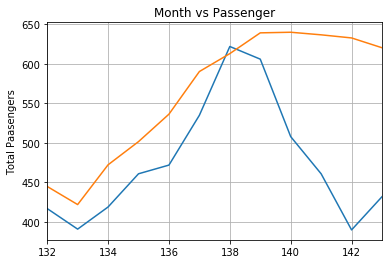

In [70]:
#그래프로 표현
plt.title('Month vs Passenger')
plt.ylabel('Total Paasengers')
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x, actual_predictions)
plt.show()